# Experiment with `Data Assimilation- Observed-simulation ENKF`

In [1]:
import sys 
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')

import Bmi_da_ENKF_forSBMI
import EnKF
import sys

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
#sys.path.append('/Assimilators_FTD/NextGen---The-Simulators-/NextGen---The-Simulators-/USGS/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT/KalmanFilters/NextGen---The-Simulators-/Toy_Model/Assimilation/NextGen---The-Simulators-/USGS/USGS_BMI_FT')
sys.path.insert(0, '../USGS/USGS_BMI_FT')
import bmi_usgs


In [2]:
EnKF_instance = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()
cfe_instance_peturb = bmi_cfe_peturb.BMI_CFE()
cfe_instance = bmi_cfe.BMI_CFE() #one that changes state vars

print("Input variables:\n")
print("USGS")
print(usgs.get_input_var_names())
print("CFE")
print(cfe_instance_peturb.get_input_var_names())
print("EnKF")
print(EnKF_instance.get_input_var_names())

print("\nOutput variables:")
#print(cfe_assimilation.get_output_var_names())
print(usgs.get_output_var_names())


Input variables:

USGS
['sites', 'service', 'start', 'end']
CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux']
EnKF
['x', 'P', 'z', 'dt', 'N', 'look_up_table']

Output variables:
['Flow', 'validity']


In [3]:
EnKF_instance.initialize(cfg_file='./Assimilation/EnKF_config.json')
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_instance_peturb.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')

In [4]:
EnKF_instance.set_value('x',np.array([50]))

In [5]:
print('x',EnKF_instance.get_value('x'))
EnKF_instance.update()
print('x',EnKF_instance.get_value('x'))

x [50]
prior [499.72868521]
x_post [319.36666502]
x [50]
x [50]


                           Date    Flow  validity
0     2016-04-14 06:00:00+00:00  78.650       1.0
1     2016-04-14 07:00:00+00:00  75.675       1.0
2     2016-04-14 08:00:00+00:00  72.050       1.0
3     2016-04-14 09:00:00+00:00  69.675       1.0
4     2016-04-14 10:00:00+00:00  68.000       1.0
...                         ...     ...       ...
21836 2018-10-11 02:00:00+00:00  30.750       1.0
21837 2018-10-11 03:00:00+00:00  31.050       1.0
21838 2018-10-11 04:00:00+00:00  31.050       1.0
21839 2018-10-11 05:00:00+00:00  30.750       1.0
21840 2018-10-11 06:00:00+00:00  31.050       1.0

[21841 rows x 3 columns]
USGS station ID 06006000
prior [-0.0187267]
x_post [0.63697923]
x [0.]
prior [0.49037412]
x_post [0.84878841]
x [0.]
prior [-0.21248967]
x_post [0.10657223]
x [0.]
prior [0.07112802]
x_post [0.95202362]
x [0.]
prior [0.00771482]
x_post [0.69442802]
x [0.]
prior [0.23530218]
x_post [0.38868858]
x [0.]
prior [-0.1244335]
x_post [0.46642262]
x [0.]
prior [0.00526242]
x_post 

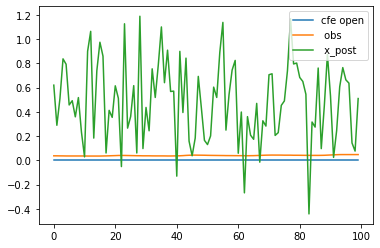

In [6]:
# ## Open BMI's for each file
cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
cfe_analysis = bmi_cfe.BMI_CFE() #true model in the end
# #enkf = Bmi_da_ENKF.EnsembleKalmanFilter()
# usgs = bmi_usgs.BMI_USGS()
# ######################################################################
# EnKF_instance.initialize(cfg_file='./Assimilation/EnKF_config.json')
# usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')
cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_open.initialize (cfg_file='./CFE/cat_58_config_cfe.json')
# ######################################################################

with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)

#print(df_forcing)
#####################################
cfeOpen = []
cfePeturbed = []
sim = []
obs = []
assimilation = []
x_post=[]
x_prior=[]
factor=[]

# Update usgs data and get value to put into EnKF
usgs.update()
obs = usgs.get_value('Flow')

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    obs=np.array(usgs.get_value('Flow'))
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()   
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow)
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean)
    
    # EnKF
    EnKF_instance.set_value('x',np.array([outflow_peturb_mean]))
    EnKF_instance.set_value('P',np.array([outflow_peturb_covar]))
    EnKF_instance.set_value('z',np.array([obs[i]]))
    # EnKF_instance.set_value('dt', framework_time)
    # EnKF_instance.set_value('F', framework_time
    
    fac=EnKF_instance.get_value('factor')
    xpo=EnKF_instance.get_value('x_post')
    xpr=EnKF_instance.get_value('x_prior')
    
    EnKF_instance.set_value('z',np.array([obs[i]/10]))
    # print(EnKF_instance.get_value('x'))
    EnKF_instance.update()
    # print(EnKF_instance.get_value('x_prior'))
    # print(obs[i])
    x_post.append(xpo)
    x_prior.append(xpr)
    factor.append(fac)
       
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    #enkf.set_value(obs, outflow_peturb_mean, outflow_peturb_covar)
    #state_transition = enkf.get_value('What are we getting?')
    
    # Set value for CFE analysis to get true streamflow. Update then
    #cfe_analysis.set_value(state_transition)   
    #cfe_analysis.update()
    
    # Update final model from value of analysis
    #cfe_updated_everything = cfe_analysis.get_value('Streamflow?')
    #cfe_perturbed.set_value(cfe_updated_everything)
    
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize()
#cfe_analysis.finalize()
usgs.finalize()
#enkf.finalize()
plt.plot(cfeOpen[100:200],label='cfe open')
plt.plot(obs[100:200]/1000,label=' obs')
plt.plot(x_post[100:200],label=' x_post')
# plt.plot(x_prior,label=' x_prior')
plt.legend(loc=1)
# print(EnKF_instance.get_value('x_post'))